In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from copy import deepcopy
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.vocs import VOCS

vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)
generator = BayesianExplorationGenerator(vocs)

<Axes: >

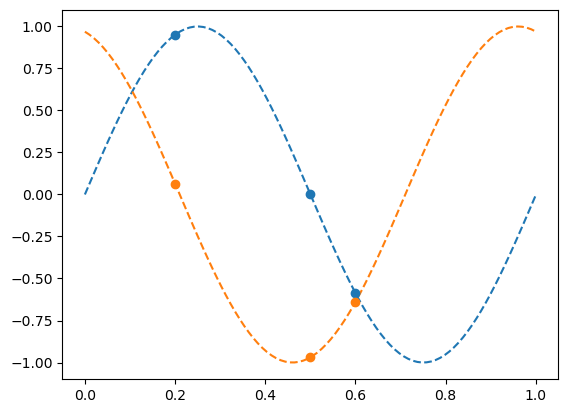

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Normal Model with Standard transforms and no constraints
- acquisition function is UCB with beta = 2

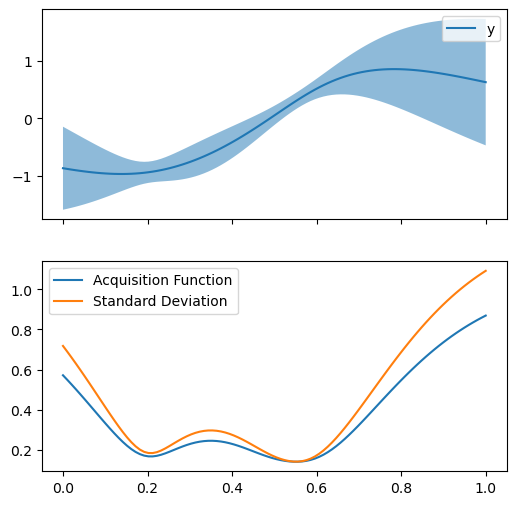

In [3]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.vocs.constraints = {}

generator.add_data(data)
model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

# Normal Model with Standard transforms and constraints

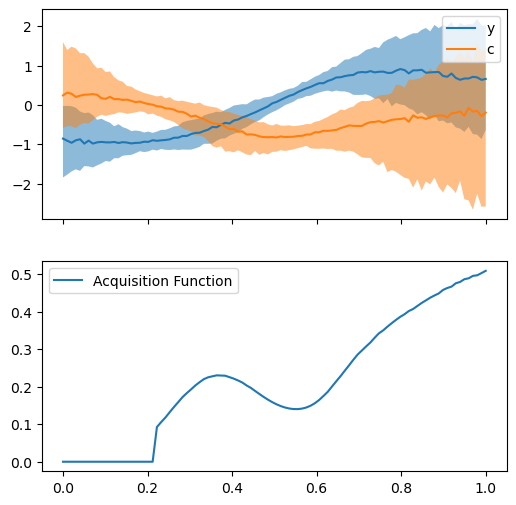

In [4]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.vocs.constraints = {"c": ["LESS_THAN", 0]}

generator.add_data(data)
model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    n_samples = torch.Size([512])
    for i in range(len(post.posteriors)):
        mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
        l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
        u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
        ax[0].plot(test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
    ax[0].legend()

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

# Normal Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be biased away from the sides due to the prior
mean (note that the lengthscale is long so its not heavily biased)

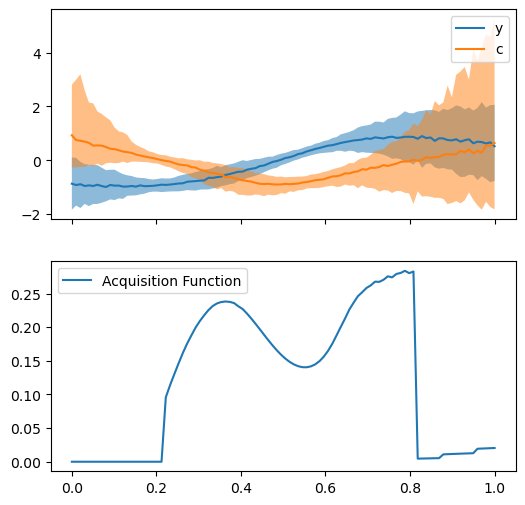

In [5]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.model.kwargs.use_conservative_prior_mean = True

model = generator.train_model(data)

generator.add_data(data)
model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    n_samples = torch.Size([512])
    for i in range(len(post.posteriors)):
        mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
        l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
        u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
        ax[0].plot(test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
    ax[0].legend()

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

# Conservative Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be heavily biased away from the sides due to the prior
mean and short prior lengthscale
- make sure to use a strong prior on the noise to reduce it

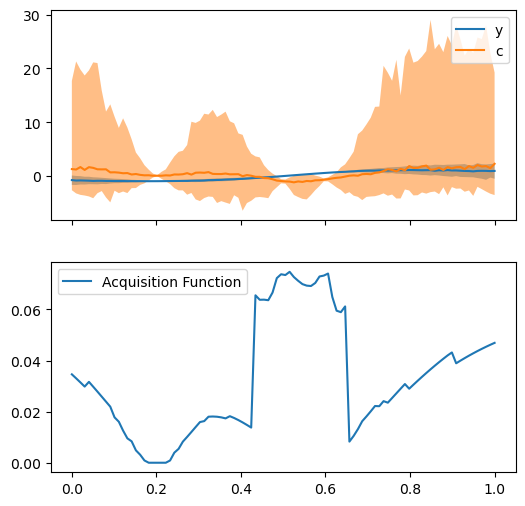

In [6]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.model.kwargs.use_conservative_prior_mean = True
generator.options.model.kwargs.use_conservative_prior_lengthscale = True
generator.options.model.kwargs.use_low_noise_prior = True

model = generator.train_model(data)

generator.add_data(data)
model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    n_samples = torch.Size([512])
    for i in range(len(post.posteriors)):
        mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
        l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
        u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
        ax[0].plot(test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
    ax[0].legend()

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

# Normal model with standard transforms and proximal biasing

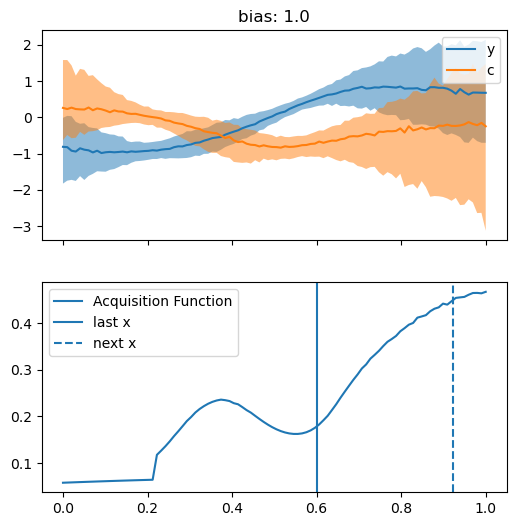

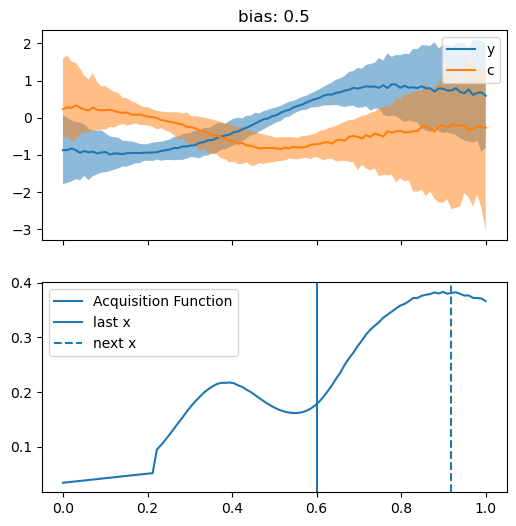

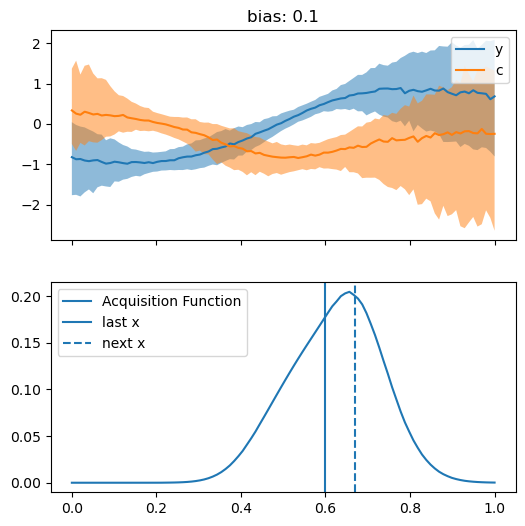

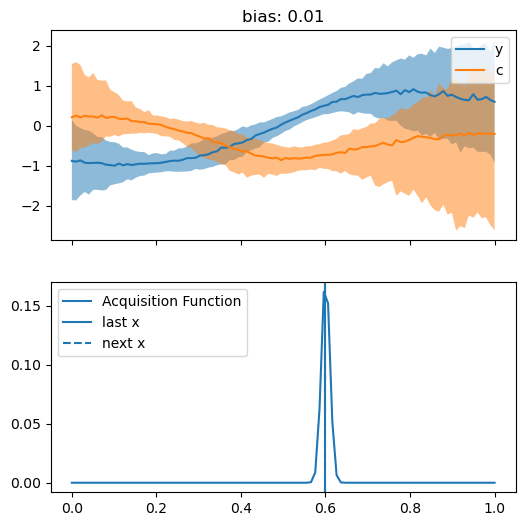

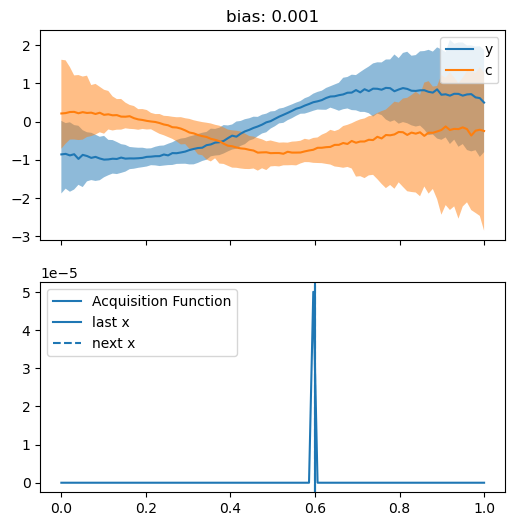

In [7]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.add_data(data)
biasing_factor = [1.0, 0.5, 0.1, 0.01,0.001]

for ele in biasing_factor:

    generator.options.acq.proximal_lengthscales = [ele]

    generator.add_data(data)
    model = generator.train_model(data)

    fig,ax = plt.subplots(2,1, sharex="all")
    fig.set_size_inches(6,6)
    with torch.no_grad():
        post = model.posterior(test_x.reshape(-1,1,1).double())

        n_samples = torch.Size([512])
        for i in range(len(post.posteriors)):
            mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
            l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
            u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
            ax[0].plot(test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
            ax[0].fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
        ax[0].legend()

        acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

        ax[1].plot(test_x, acq, label='Acquisition Function')
        ax[1].legend()

        ax[0].set_title(f"bias: {ele}")

        # add line for the last observation
        ax[1].axvline(data["x"].to_numpy()[-1],label="last x")

    # try optimizing the acq with standard settings
    candidate = generator.generate(1)
    ax[1].axvline(candidate["x"].to_numpy()[-1],ls='--', label="next x")
    ax[1].legend()

# Model with standard transforms and proximal biasing + modified ranges
- model with large input space and small output space
- Observe that numerical instabilities exist for plotting the posterior but not the
acquisition function since the acquisition function operates on the standardized model.

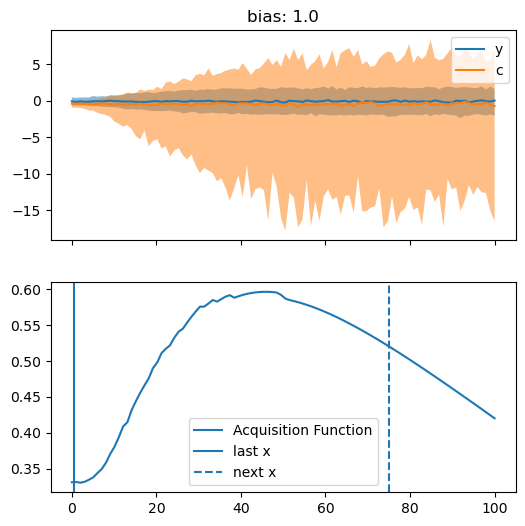

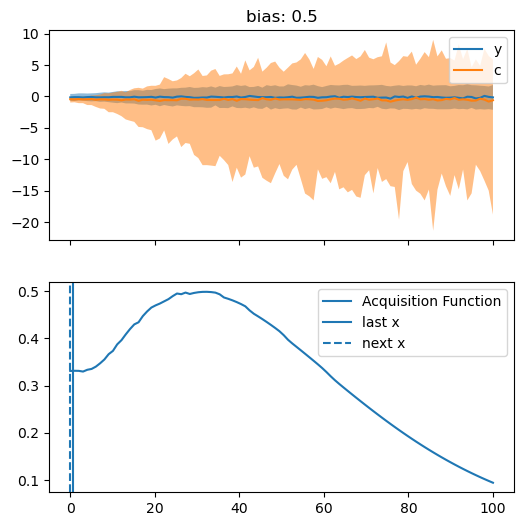

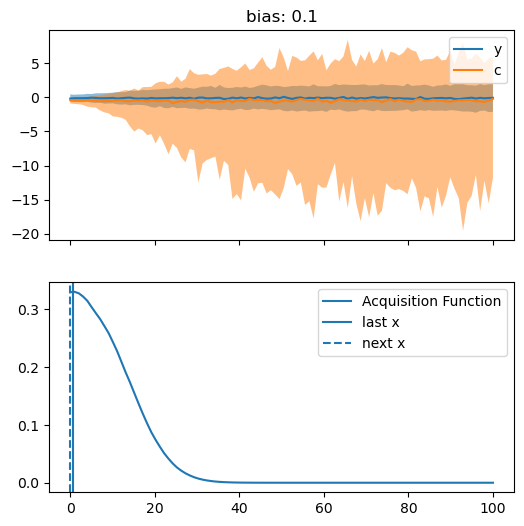

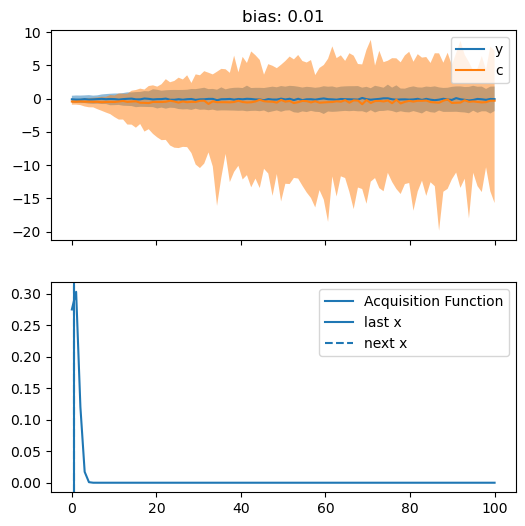

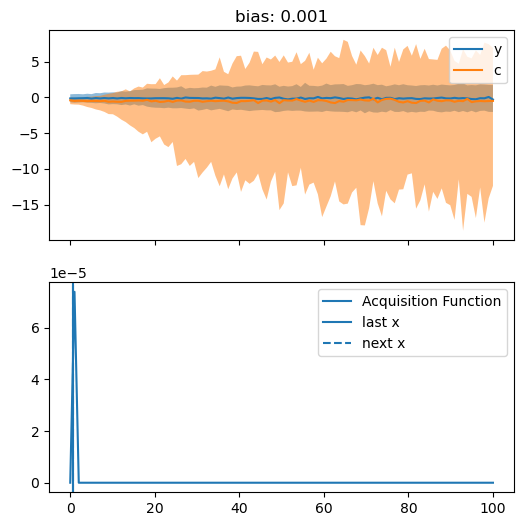

In [8]:
# plot the generator model and acquisition function
new_data = deepcopy(data)
input_scale = 1e2
output_scale = 1e-5

new_data['x'] = new_data["x"] * input_scale
new_data["y"] = new_data["y"] * output_scale

new_vocs = deepcopy(vocs)
new_vocs.variables["x"] = [0.0, input_scale]

generator = BayesianExplorationGenerator(
    new_vocs, BayesianExplorationGenerator.default_options()
)
generator.add_data(new_data)
biasing_factor = [1.0, 0.5, 0.1, 0.01,0.001]

new_test_x = test_x*input_scale

for ele in biasing_factor:

    generator.options.acq.proximal_lengthscales = [ele]

    generator.add_data(data)
    model = generator.train_model(data)

    fig,ax = plt.subplots(2,1, sharex="all")
    fig.set_size_inches(6,6)
    with torch.no_grad():
        post = model.posterior(new_test_x.reshape(-1,1,1).double())

        n_samples = torch.Size([512])
        for i in range(len(post.posteriors)):
            mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
            l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
            u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
            ax[0].plot(new_test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
            ax[0].fill_between(new_test_x, l.flatten(), u.flatten(), alpha=0.5)
        ax[0].legend()

        acq = generator.get_acquisition(model)(new_test_x.reshape(-1,1,1).double())

        ax[1].plot(new_test_x, acq, label='Acquisition Function')
        ax[1].legend()

        ax[0].set_title(f"bias: {ele}")

        # add line for the last observation
        ax[1].axvline(data["x"].to_numpy()[-1],label="last x")

    # try optimizing the acq with standard settings
    candidate = generator.generate(1)
    ax[1].axvline(candidate["x"].to_numpy()[-1],ls='--', label="next x")
    ax[1].legend()

# Model with standard transforms and proximal biasing + modified ranges 2
- model with small input space and large output space
- Observe that numerical instabilities exist for plotting the posterior but not the
acquisition function since the acquisition function operates on the standardized model.

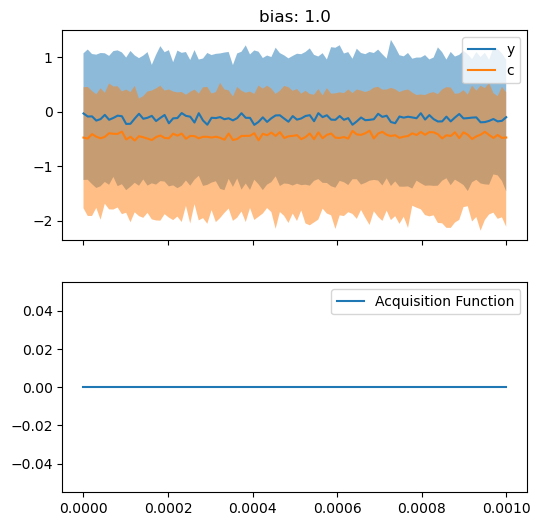

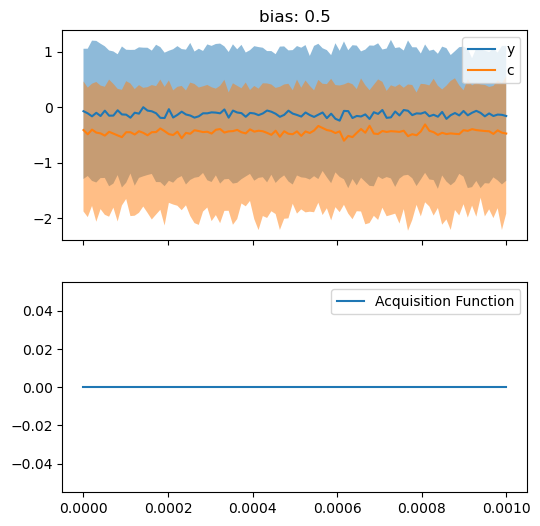

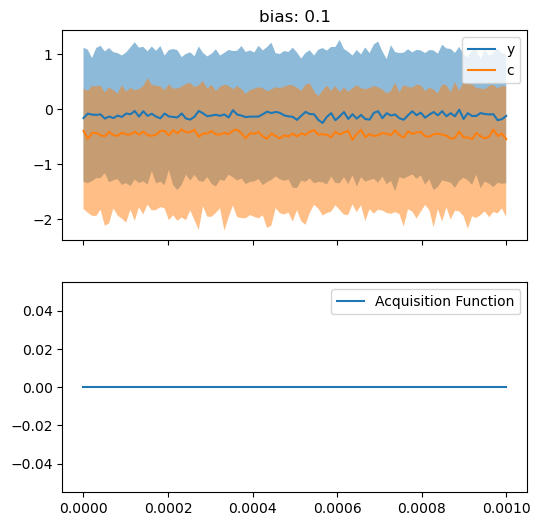

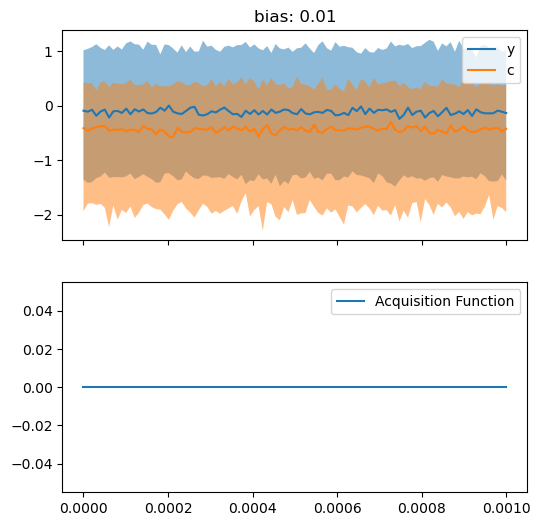

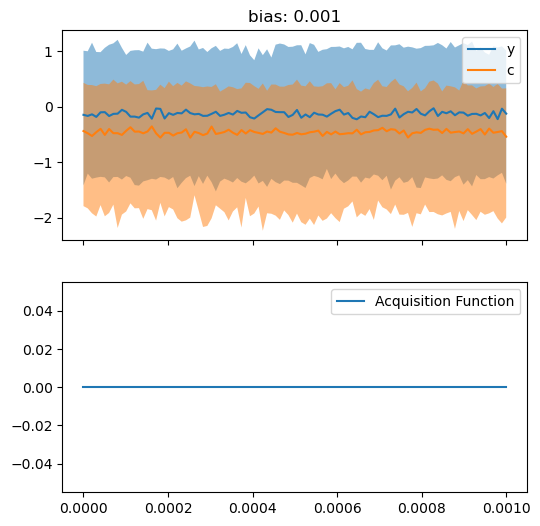

In [9]:
# plot the generator model and acquisition function
new_data = deepcopy(data)
input_scale = 1e-3
output_scale = 1e2

new_data['x'] = new_data["x"] * input_scale
new_data["y"] = new_data["y"] * output_scale

new_vocs = deepcopy(vocs)
new_vocs.variables["x"] = [0.0, input_scale]

generator = BayesianExplorationGenerator(
    new_vocs, BayesianExplorationGenerator.default_options()
)
generator.add_data(new_data)
biasing_factor = [1.0, 0.5, 0.1, 0.01,0.001]

new_test_x = test_x*input_scale

for ele in biasing_factor:

    generator.options.acq.proximal_lengthscales = [ele]

    generator.add_data(data)
    model = generator.train_model(data)

    fig,ax = plt.subplots(2,1, sharex="all")
    fig.set_size_inches(6,6)
    with torch.no_grad():
        post = model.posterior(new_test_x.reshape(-1,1,1).double())

        n_samples = torch.Size([512])
        for i in range(len(post.posteriors)):
            mean = post.posteriors[i].rsample(n_samples).quantile(0.5,dim=0)
            l = post.posteriors[i].rsample(n_samples).quantile(0.1,dim=0)
            u = post.posteriors[i].rsample(n_samples).quantile(0.9,dim=0)
            ax[0].plot(new_test_x, mean.flatten(),f"C{i}", label=generator.vocs.output_names[i])
            ax[0].fill_between(new_test_x, l.flatten(), u.flatten(), alpha=0.5)
        ax[0].legend()

        acq = generator.get_acquisition(model)(new_test_x.reshape(-1,1,1).double())

        ax[1].plot(new_test_x, acq, label='Acquisition Function')
        ax[1].legend()

        ax[0].set_title(f"bias: {ele}")

        # add line for the last observation
        #ax[1].axvline(data["x"].to_numpy()[-1],label="last x")

    # try optimizing the acq with standard settings
    candidate = generator.generate(1)
    #ax[1].axvline(candidate["x"].to_numpy()[-1],ls='--', label="next x")
    ax[1].legend()